# Introduction
In this notebook, we illustrate how to implement the Variational Quantum Eigensolver (VQE) algorithm in Amazon Braket SDK to compute the potential energy surface (PES) for the Hydrogen molecule. Specifically, we illustrate the following features of Amazon Braket SDK:
* `LocalSimulator` which allows one to simulate quantum circuits on their local machine
* Construction of the ansatz circuit for VQE in Braket SDK
* Computing expectation values of the individual terms in the Hamiltonian in Braket SDK

# Problem formulation
In computational chemistry, we are typically interested in finding the ground-state energy (i.e., minimum energy) of a molecule for a given configuration of atomic positions.
This is accomplished by finding the lowest eigenvalues and eigenstates of the molecular Hamiltonian.
## Molecular Hamiltonian
In [atomic units](https://en.wikipedia.org/wiki/Hartree_atomic_units), the full molecular Hamiltonian takes the form [1],

$$
H_{full} = - \sum_i \frac{\nabla_i^2}{2} - \sum_I \frac{\nabla_I^2}{2 M_I}
    - \sum_{i,I} \frac{Z_I}{|\mathbf{r}_i - \mathbf{R}_I|}
    + \frac{1}{2} \sum_{i \neq j} \frac{1}{|\mathbf{r}_i - \mathbf{r}_j|}
    + \frac{1}{2} \sum_{I \neq J} \frac{1}{|\mathbf{R}_I - \mathbf{R}_J|}
\tag{1}
$$

where $i$ and $I$ label the electrons and nuclei respectively.
Here $\mathbf{r}_i$ and $\mathbf{R}_I$ denote the electron and nucleus positions, $Z_I$ denotes nuclear charge, and $M_I$ denotes nuclear mass respectively.
The first two terms in Eq.(1) represent the electronic and nuclear kinetic energy, while the remaining terms denote the Coulombic interaction between the nuclei and electrons, amongst the electrons, and amongst the nuclei respectively.

Since we are mostly interested in the electronic structure of the molecule, we invoke the [Born-Oppenheimer approximation](https://en.wikipedia.org/wiki/Born%E2%80%93Oppenheimer_approximation), which is based on the fact that nuclei are over a thousand times heavier than electrons.
This approximation allows us to reduce the problem to finding the eigenvalues of the following electronic Hamiltonian for a given nuclear configuration [1], i.e., fixed set of nuclear positions $\{\mathbf{R}_I\}$,

$$
H = - \sum_i \frac{\nabla_i^2}{2}
    - \sum_{i,I} \frac{Z_I}{|\mathbf{r}_i - \mathbf{R}_I|}
    + \frac{1}{2} \sum_{i \neq j} \frac{1}{|\mathbf{r}_i - \mathbf{r}_j|}
\tag{2}
$$

## Second quantization
In order to determine the eigenvalues and eigenstates of the electronic Hamiltonian of a molecule given in Eq. (2), we start with a set of single-electron basis functions (also called *spin orbitals*), $\{\phi_p(\mathbf{x}_i)\}$, where $\mathbf{x}_i=(\mathbf{r}_i, s_i)$ denotes the spatial position and spin of the $i$-th electron.
The many-electron wavefunction is expressed as a [Slater determinant](https://en.wikipedia.org/wiki/Slater_determinant) of these basis functions, i.e., as an antisymmetrized product of the single-electron basis functions, so that the electrons automatically satisfy the [Pauli exclusion principle](https://en.wikipedia.org/wiki/Pauli_exclusion_principle).
While the total number of single-electron basis functions considered $M$, is typically larger than the total number of electrons $N$, in the molecule, the $N$ electrons can only occupy $N$ ($< M$) of these orbitals in a Slater determinant, i.e., a Slater determinant contains only $N$ occupied orbitals [1].
Since any Slater determinant of the basis functions is uniquely determined by which orbitals are occupied, a Slater determinant can be represented in an abstract vector space, called the *Fock space*, by an *occupation number* vector $|f\rangle = |f_{M-1}, \ldots, f_0 \rangle$ where each $f_i$ is either 0 or 1 depending on whether the $i$-th orbitals is unoccupied or occupied respectively in the Slater determinant.

Next, we introduce a set of operators $\{a_p, a_p^\dagger\}$ , called the fermion *annihilation* and *creation* operators respectively, corresponding to each of the basis functions $\{\phi_p(\mathbf{x}_i)\}$, which satisfy the anticommutation relations,

$$
\{a_p, a_q\} = \{a_p^\dagger, a_q^\dagger\} = 0, \qquad \{a_p, a_q^\dagger\} = \delta_{pq}
\tag{3}
$$

where the anticommutator of two operators $C$ and $D$ is defined as $\{C,D\} = CD + DC$ and $\delta_{cd}$ denotes the Kronecker delta.

Expressing the electronic Hamiltonian in Eq. (2) in terms of these fermionic operators we get [1],

$$
H = \sum_{p,q} h_{pq} a_p^\dagger a_q 
    +\frac{1}{2} \sum_{p,q,r,s} h_{pqrs} a_p^\dagger a_q^\dagger a_r a_s
\tag{4}
$$

where,

$$
h_{pq} = \int d\mathbf{x}\ \phi_p^*(\mathbf{x}) \left( -\frac{\nabla^2}{2} - \sum_I \frac{Z_I}{|\mathbf{r} - \mathbf{R}_I|} \right) \phi_q(\mathbf{x})
\tag{5}
$$

and

$$
h_{pqrs} = \int d\mathbf{x}_1 d\mathbf{x}_2\ \frac{\phi_p^*(\mathbf{x}_1) \phi_q^*(\mathbf{x}_2)\phi_s(\mathbf{x}_1)\phi_r(\mathbf{x}_2)}{|\mathbf{r}_1 - \mathbf{r}_2|}
\tag{6}
$$

### Basis sets
A variety of basis sets are used in computational chemistry depending on the chemical system being studied and the accuracy required, e.g.,
* [STO-$n$G][r8] (also called *minimal basis sets*)
* [Split-valence][r9]
* [Correlation-consistent][r9]
* [Polarization-consistent][r9]
* [Plane-wave][r9]

[r8]: https://en.wikipedia.org/wiki/STO-nG_basis_sets

[r9]: https://en.wikipedia.org/wiki/Basis_set_(chemistry) 

## Hartree-Fock method
The [Hartree-Fock (HF)](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) method is the starting point for most computational chemistry calculations of atoms and molecules [1].
The HF method aims to find the single-most dominant Slater determinant that best approximates the system wavefunction by optimizing the spatial form of the spin orbitals in a self-consistent fashion (hence, also called *self-consistent field* or SCF method) to minimize the energy of the wavefunction.
The Slater determinant generated by the optimized spin orbitals (also known as *canonical orbitals*) computed from the HF method is used as the reference state for post Hartree-Fock methods that try to correct for some of the approximations in the HF method.
### Post Hartree-Fock methods
There are a variety of post Hartree-Fock (post-HF) methods employed in classical computational chemistry to improve upon the accuracy of a simple HF computation to varying degrees [1], e.g.,
* [Configuration interaction and Full Configuration Interaction](https://en.wikipedia.org/wiki/Configuration_interaction)
* [Multi-configurational self-consistent field](https://en.wikipedia.org/wiki/Multi-configurational_self-consistent_field)
* [Coupled cluster](https://en.wikipedia.org/wiki/Coupled_cluster)
* [Perturbation theory](https://en.wikipedia.org/wiki/M%C3%B8ller%E2%80%93Plesset_perturbation_theory)

## Mapping to quantum computer
In order to represent the electronic Hamiltonian of the molecular system under study, we need to map it to operators that act on the qubits of a quantum computer.
There are various encoding techniques to accomplish this, e.g., parity encoding, Bravyi-Kitaev encoding, etc., but the simplest one is the Jordan-Wigner encoding [2].
### Jordan-Wigner encoding
In the Jordan-Wigner (JW) encoding, we store the occupation number of an orbital $f_i$ in the $i$-th qubit $q_i$ as either $|0\rangle$ or $|1\rangle$ depending on whether the orbital is unoccupied or occupied respectively.
Correspondingly, the fermionic annihilation and creation operators are mapped to the qubit operators as

$$
a_p = Q_p \otimes Z_{p-1} \otimes \ldots \otimes Z_0
\tag{7}
$$

and

$$
a_p^\dagger = Q_p^\dagger \otimes Z_{p-1} \otimes \ldots \otimes Z_0
\tag{8}
$$

where $Q = |0\rangle \langle 1|, Q^\dagger = |1\rangle \langle 0|$, $Z=|0\rangle \langle 0| - |1\rangle \langle 1| $ denotes the Pauli-Z matrix and $\otimes$ denotes the tensor product.
This shows that in the JW encoding, while the occupation of an orbital is stored locally, i.e., in a single qubit, the parity is stored non-locally.
This makes JW encoding not as efficient compared to other encoding techniques, e.g., Bravyi-Kitaev encoding, but for small systems with a few qubits, the efficiency gap is not significant.

## Variational Quantum Eigensolver
One of the most promising algorithms for performing quantum chemistry computations on the NISQ (noisy intermediate-scale quantum) era quantum computers we can currently use is the variational quantum eigensolver (VQE) [2].
VQE is a hybrid quantum-classical algorithm using the quantum computer only for a classically intractable subroutine and has been shown to be robust against noise [2,4], and capable of finding ground-state energies of small molecules using low-depth quantum circuits.

VQE is based on the Raleigh-Ritz variational principle: for a trial wavefunction $|\psi(\vec{\theta})\rangle$ parameterized by a vector parameter $\vec{\theta}$ for a system with Hamiltonian $H$, whose lowest energy eigenvalue is $E_0$ [2],

$$
\langle \psi(\vec{\theta}) | H | \psi(\vec{\theta}) \rangle \geq E_0
\tag{9}
$$

Thus, VQE reduces the problem of finding the ground-state energy of the system Hamiltonian to finding the optimum value of the vector parameter $\vec{\theta}$.
The parameterized wavefunction $|\psi(\vec{\theta})\rangle$ is prepared on a quantum computer by applying a series of parameterized unitary gates (also called a *parameterized circuit*) to the qubits initialized in some reference state $|\psi_{ref}\rangle$, e.g., a HF state, as [2] 

$$
|\psi(\vec{\theta})\rangle = U(\vec{\theta}) | \psi_{ref} \rangle
\tag{10}
$$

As classical computers are unable to efficiently prepare, store and measure the expectation value of the Hamiltonian $H$ for the parameterized 
wavefunction $|\psi(\vec{\theta})\rangle$, we use the quantum computer for this subroutine, and then use the classical computer to update the parameters using an optimization algorithm.

To complete the specification of VQE, one needs to specify the form of the parameterized wavefunction $|\psi(\vec{\theta})\rangle$, known as the *ansatz*. A popular chemically-inspired ansatz for VQE is the unitary coupled cluster ansatz truncated to singles and doubles excitations (UCCSD).
### UCCSD ansatz
The unitary coupled cluster (UCC) method is an extension of the coupled-cluster (CC) method, which is one of the most popular post-HF methods [2].
In the UCC method, the parameterized trial function is given by

$$
U(\vec{\theta}) = e^{T - T^\dagger}
\tag{11}
$$

where $T = \sum_i T_i$ is the sum of various excitation levels, e.g.,

$$
T_1 = \sum_{i \in virt, \alpha \in occ} \theta_{i \alpha} a_i^\dagger a_\alpha, \qquad
T_2 = \sum_{i, j \in virt, \alpha, \beta \in occ} \theta_{i j \alpha \beta} a_i^\dagger a_j^\dagger a_\alpha a_\beta, \ldots
\tag{12}
$$

denote the single and double excitation levels respectively.

The UCC method possesses all the advantages of the CC method and is also fully variational as well as able to converge when using multi-reference states. As in CC, we truncate the expression for $T$ at a given excitation level -- usually single and double excitations leading to the UCCSD ansatz [2].

## The Hydrogen molecule
For simplicity, we use the minimal basis set STO-3G for $H_2$ molecule, which includes only the $\{1s\}$ orbital for each $H$ atom.
Since each $H$ atom contributes one spin-orbital, and there are 2 possible spins for each orbital (up or down), this leads to a total of 4 orbitals for $H_2$ in the STO-3G basis set [2],
$$
| 1s_{A\uparrow} \rangle, | 1s_{A\downarrow} \rangle, | 1s_{B\uparrow} \rangle, | 1s_{B\downarrow} \rangle
\tag{13}
$$
where the subscripts A and B label the $H$ atom and $\uparrow/\downarrow$ label the electron spin respectively.

In the molecular orbital basis for $H_2$, given by [2]
$$
| \sigma_{g \uparrow} \rangle = \frac{1}{\sqrt{2}} ( | 1s_{A\uparrow} \rangle + | 1s_{B\uparrow} \rangle) \\
| \sigma_{g \downarrow} \rangle = \frac{1}{\sqrt{2}} ( | 1s_{A\downarrow} \rangle + | 1s_{B\downarrow} \rangle) \\
| \sigma_{u \uparrow} \rangle = \frac{1}{\sqrt{2}} ( | 1s_{A\uparrow} \rangle - | 1s_{B\uparrow} \rangle) \\
| \sigma_{u \downarrow} \rangle = \frac{1}{\sqrt{2}} ( | 1s_{A\downarrow} \rangle - | 1s_{B\downarrow} \rangle)
\tag{14}
$$
the Slater determinant can be expressed in the occupation number basis as
$$
| \psi \rangle = | f_{u\downarrow}, f_{u\uparrow}, f_{g\downarrow}, f_{g\uparrow} \rangle = | f_3, f_2, f_1, f_0 \rangle
\tag{15}
$$
where each $f_i \in \{0,1\}$.

The second-quantized electronic Hamiltonian in this basis is given by [2]
$$
H = H_1 + H_2 + H_3 + H_4
\tag{16}
$$

where

$$
H_1 = h_{00} a_0^\dagger a_0 + h_{11} a_1^\dagger a_1 + h_{22} a_2^\dagger a_2 + h_{33} a_3^\dagger a_3,
\tag{17}
$$

$$
H_2 = h_{0110} a_0^\dagger a_1^\dagger a_1 a_0 + h_{2332} a_2^\dagger a_3^\dagger a_3 a_2 + h_{0330} a_0^\dagger a_3^\dagger a_3 a_0 + h_{1221} a_1^\dagger a_2^\dagger a_2 a_1,
\tag{18}
$$

$$
H_3 = (h_{0220}-h_{0202}) a_0^\dagger a_2^\dagger a_2 a_0 + (h_{1331} - h_{1313}) a_1^\dagger a_3^\dagger a_3 a_1,
\tag{19}
$$

and

$$
H_4 = h_{0132} (a_0^\dagger a_1^\dagger a_3 a_2 + a_2^\dagger a_3^\dagger a_1 a_0) + h_{0312} (a_0^\dagger a_3^\dagger a_1 a_2 + a_2^\dagger a_1^\dagger a_3 a_0)
\tag{20}
$$

where the coefficients $h$ are given by Eqs. (5) and (6).

Using the JW encoding, the electronic Hamiltonian for $H_2$ in Eq.(16) can be expressed as a 4-qubit operator [2]

$$
H_Q = H_{Q1} + H_{Q2} + H_{Q3}
\tag{21}
$$

where

$$
H_{Q1} = h_0 I + h_1 Z_0 + h_2 Z_1 + h_3 Z_2 + h_4 Z_3,
\tag{22}
$$

$$
H_{Q2} = h_5 Z_0 Z_1 + h_6 Z_0 Z_2 + h_7 Z_1 Z_2 + h_8 Z_0 Z_3 + h_9 Z_1 Z_3 + h_{10} Z_2 Z_3,
\tag{23}
$$

and
$$
H_{Q3} = h_{11} Y_0 Y_1 X_2 X_3 + h_{12} X_0 Y_1 Y_2 X_3 + h_{13} Y_0 X_1 X_2 Y_3 + h_{14} X_0 X_1 Y_2 Y_3
\tag{24}
$$

In the JW encoding, the HF state, which is taken as the reference state for the UCCSD ansatz for VQE, is given by,

$$
| \psi_{HF} \rangle = | 0011 \rangle
\tag{25}
$$

which represents the state in which the molecular orbitals $| \sigma_{g \uparrow} \rangle$ and $| \sigma_{g \downarrow} \rangle$ are occupied, while the molecular orbitals $| \sigma_{u \uparrow} \rangle$ $| \sigma_{u \downarrow} \rangle$ are unoccupied.
The most general state for $H_2$ with the same charge and spin multiplicity as the HF state can be expressed as [2],

$$
| \psi \rangle = \alpha | 0011 \rangle + \beta | 1100 \rangle + \gamma | 1001 \rangle + \delta | 0110 \rangle
\tag{26}
$$

Finally, the UCCSD ansatz for $H_2$ in the STO-3G basis can be simplified to the following single-parameter unitary operator acting on the HF reference state given by Eq. (25) [2]

$$
U (\theta) = e^{\imath \theta X_3 X_2 X_1 Y_0}
\tag{27}
$$

# Implementation details
We use the following procedure to determine the ground-state energy of the $H_2$ molecule at various bond-lengths, i.e., its potential energy surface (PES).
1. We use OpenFermion-PySCF to compute the coefficients of the different terms of the 4-qubit operator in Eq.(21) representing the electronic Hamiltonian for $H_2$ at the required bond lengths of $H_2$ molecule.
1. Using Amazon Braket, we implement the UCCSD ansatz given by Eq.(27) through the quantum circuit shown below [2].
1. We run the above quantum circuit using the local simulator of Amazon Braket for various values of the parameter in the UCCSD ansatz to determine its optimal value and using this value, compute the expectation value of the qubit operator in Eq.(21) to get the estimated ground-state energy of $H_2$ for each value of bond-length.

Finally, we assess the accuracy of the ground-state energy of $H_2$ molecule  for various bond-lengths computed by VQE to that computed using the classical chemistry post-HF method FCI (full configuration interaction), which is the most accurate computation that can be performed for a given basis set.

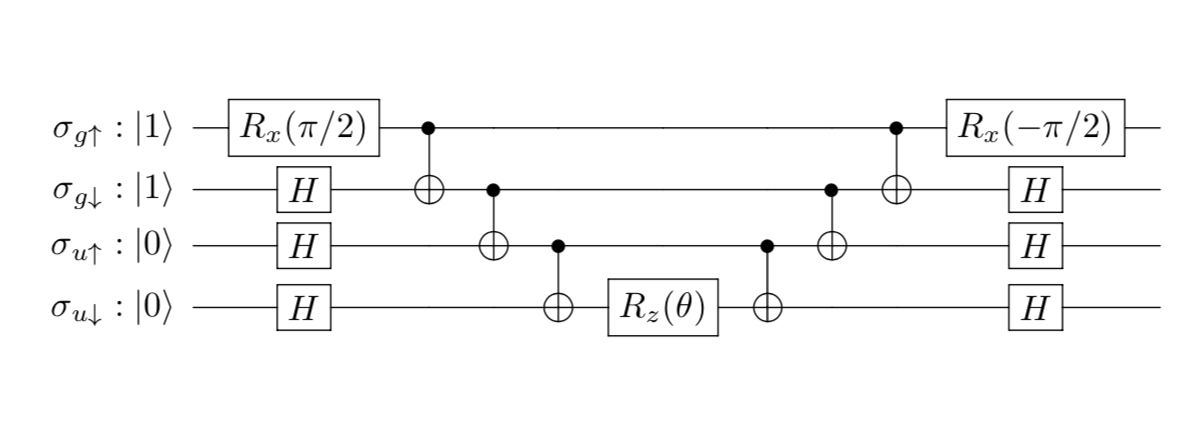

## Pre-requisites
* Install [Braket Python SDK](https://github.com/aws/amazon-braket-sdk-python) by following the instruction provided in the repository.

# Execution
## Imports and setup

In [1]:
# create a directory named "data" to store intermediate classical computation results from OpenFermion
!mkdir -p "data"
!pip show amazon-braket-sdk

Name: amazon-braket-sdk
Version: 1.5.9
Summary: An open source library for interacting with quantum computing devices on Amazon Braket
Home-page: https://github.com/aws/amazon-braket-sdk-python
Author: Amazon Web Services
Author-email: None
License: Apache License 2.0
Location: /Users/chauvira/opt/anaconda3/lib/python3.8/site-packages
Requires: boltons, nest-asyncio, networkx, backoff, boto3, amazon-braket-default-simulator, numpy
Required-by: 


In [2]:
# import required libraries
import os
import time
import numpy as np
from matplotlib import pyplot as plt
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf
from braket.circuits import Circuit, FreeParameter, observables
from braket.devices import LocalSimulator

## Parameters defining the problem space

In [3]:
# Initialize variable to determine total run-time of the program
run_time = time.time()
# Set parameters that won't change for all simulations
# total charge
tot_chg = 0
# set the multiplicity
# this parameter specifies how electrons are paired in orbitals
# spin multiplicity is equal to the number of unpaired electrons plus one
# e.g., spin multiplicity = 1 implies no unpaired electron, i.e., for every
# spin-up electron in a spatial orbital there is a spin-down electron,
# spin-multiplicity = 3 implies 2 unpaired electrons, and so on.
# See https://en.wikipedia.org/wiki/Multiplicity_(chemistry) for more details
spin_mult = 1
# use the minimal basis set (STO-3G)
basis_set = 'sto-3g'
# number of active electrons and orbitals to consider
# For H2 as we're consider all electrons and orbitals as active for STO-3G
occ_ind = act_ind = None
# bond lengths to simulate ground-state of H2 for (in Angstroms)
bond_lengths = np.arange(start=0.24, stop=3.00, step=0.1)
# no. of bond lengths to simulate H2 for
n_configs = len(bond_lengths)
print(f"INFO: Simulating ground-state of H2 molecule for {n_configs} bond lengths")
# no. of VQE parameter values to scan
n_theta = 24
# no. of shots for measurements on quantum device
n_shots = 2000

INFO: Simulating ground-state of H2 molecule for 28 bond lengths


## Classical pre-computation of electronic Hamiltonian of $H_2$

In [4]:
# Dictionary to store molecular data and qubit Hamiltonians for each
# molecular configuration(i.e., bond length)
mol_configs = {}
# Store molecular config data and Hamiltonian for each bond length
for rr in bond_lengths:
    # round to 2 digits to get a reasonable-length number for bond-length
    r = round(rr,2)
    print(f"INFO: Computing Hamiltonian for bond-length {r} A...")
    geom = [('H', (0., 0., -r/2.)), ('H', (0., 0., r/2.))]
    # Make sure a directory named 'data' exists in the current folder,
    # else this statement will throw an error!
    h2_molecule = MolecularData(
        geometry=geom, basis=basis_set, multiplicity=spin_mult,
        description='bondlength_'+str(r)+'A', filename="",
        data_directory=os.getcwd()+'/data')
    # Run PySCF to get molecular integrals, HF and FCI energies
    h2_molecule = run_pyscf(molecule=h2_molecule, run_scf=True,
                            run_mp2=False, run_cisd=False,
                            run_ccsd=False, run_fci=True, verbose=False)
    # Convert electronic Hamiltonian to qubit operator using JW encoding
    h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(
        h2_molecule.get_molecular_hamiltonian(occupied_indices=occ_ind,
                                              active_indices=act_ind)))
    # store molecular data and qubit operator for this config in an ordered list
    mol_configs[r] = [h2_molecule, h2_qubit_hamiltonian]
print(f"INFO: Computed Hamiltonians for {len(mol_configs)} bond-lengths.")

INFO: Computing Hamiltonian for bond-length 0.24 A...
INFO: Computing Hamiltonian for bond-length 0.34 A...
INFO: Computing Hamiltonian for bond-length 0.44 A...
INFO: Computing Hamiltonian for bond-length 0.54 A...
INFO: Computing Hamiltonian for bond-length 0.64 A...
INFO: Computing Hamiltonian for bond-length 0.74 A...
INFO: Computing Hamiltonian for bond-length 0.84 A...
INFO: Computing Hamiltonian for bond-length 0.94 A...
INFO: Computing Hamiltonian for bond-length 1.04 A...
INFO: Computing Hamiltonian for bond-length 1.14 A...
INFO: Computing Hamiltonian for bond-length 1.24 A...
INFO: Computing Hamiltonian for bond-length 1.34 A...
INFO: Computing Hamiltonian for bond-length 1.44 A...
INFO: Computing Hamiltonian for bond-length 1.54 A...
INFO: Computing Hamiltonian for bond-length 1.64 A...
INFO: Computing Hamiltonian for bond-length 1.74 A...
INFO: Computing Hamiltonian for bond-length 1.84 A...
INFO: Computing Hamiltonian for bond-length 1.94 A...
INFO: Computing Hamiltonian 

## Construction of UCCSD ansatz circuit in Braket

In [5]:
# Construct circuit for UCCSD ansatz parameterized by VQE parameter per McArdle et al. 
a_theta = FreeParameter("a_theta")
# Initialize HF state |0011>
ansatz_uccsd = Circuit().x(2).x(3)
# Perform intial rotations to measure in Y & X bases
ansatz_uccsd.rx(3,np.pi/2.).h(range(3))
# Entangle with CNOTs
ansatz_uccsd.cnot(3,2).cnot(2,1).cnot(1,0)
# Perform the rotation in Z-basis
ansatz_uccsd.rz(0,a_theta)
# Uncompute the rotations
ansatz_uccsd.cnot(1,0).cnot(2,1).cnot(3,2)
ansatz_uccsd.h(range(3))
ansatz_uccsd.rx(3,-np.pi/2.)

# initialize quantum device to run VQE over
local_sim = LocalSimulator()
# verify by running the circuit with no rotation and verifying we get HF state
print(ansatz_uccsd)
n_qubits = ansatz_uccsd.qubit_count
print(f"Total number of qubits in the circuit: {n_qubits}")
# We can fix the value of a_theta by calling the circuit with the value filled as follows.
# print(local_sim.run(ansatz_uccsd(0)).result().state_vector)
print(local_sim.run(ansatz_uccsd(0), shots=n_shots).result().measurement_probabilities)

T  : |0|   1    |2|3|4|     5     |6|7|8|    9    |
                                                   
q0 : -H--------------X-Rz(a_theta)-X-H-------------
                     |             |               
q1 : -H------------X-C-------------C-X-H-----------
                   |                 |             
q2 : -X-H--------X-C-----------------C-X-H---------
                 |                     |           
q3 : -X-Rx(1.57)-C---------------------C-Rx(-1.57)-

T  : |0|   1    |2|3|4|     5     |6|7|8|    9    |
Total number of qubits in the circuit: 4
{'0011': 1.0}


## Computation of expectation value of Hamiltonian operator for $H_2$

In [6]:
def calculate_observable_expectation(a_indices_gates, a_ckt, a_dev, a_shots):
    """ Calculates the expectation value of the given observable
    Parameters:
        a_indices_gates [sequence(tuple(int, str))]: List of tuple of qubit index & observable
        a_ckt [Circuit]: Braket circuit to which measurement gates are to be added
        a_dev [Braket Device]: Quantum device to run a_ckt on
        a_shots [int]: No. of shots for measuring in bases other than the computational basis
    Returns:
        float: The expectation value of the observable
    """
    if not a_indices_gates:
        # this is the constant term of the Hamiltonian
        return 1
    factors = {}
    for ind, factor in a_indices_gates:
        # N.B.: Convert from OpenFermion's little-endian convention to Braket's big-endian convention
        qubit = n_qubits - 1 - ind
        if factor == "X":
            factors[qubit] = observables.X()
        elif factor == "Y":
            factors[qubit] = observables.Y()
        elif factor == "Z":
            factors[qubit] = observables.Z()
    qubits = sorted(factors)
    observable = observables.TensorProduct([factors[qubit] for qubit in qubits])
    # initialize measuring circuit and add expectation measurement
    measuring_ckt = Circuit().add(a_ckt).expectation(observable=observable, target=qubits)
    # compute expectation value
    return a_dev.run(measuring_ckt, shots=a_shots).result().values[0]

def H_exp(a_qH, a_ckt, a_dev, a_shots=n_shots):
    """ Get expectation value of Hamiltonian for a given circuit result.
    Parameters:
        a_qH [OpenFermion QubitHamiltonian.terms]: Dictionary of OpenFermion QubitHamiltonian operator terms
        a_ckt [Braket Circuit]: Circuit to create the final state
        a_dev [Braket Device]: Quantum device to run a_ckt on
        a_shots [int]: No. of shots for measuring in bases other than the computational basis
    Returns:
        H_e [float]: Expectation value of a_qH for a_ket
    """
    # initialize expectation value of Hamiltonian
    H_e = 0.
    # loop over each term in qubit operator
    for term in a_qH:
        # extract the real-valued coefficient for this term
        coeff = np.real(a_qH[term])
        # compute and add this term's contribution to the Hamiltonian
        H_e += coeff * calculate_observable_expectation(term, a_ckt, a_dev, a_shots)
    return H_e

## Results

In [7]:
# Loop over all bond lengths
for r in mol_configs:
    print(f"INFO: Computing ground-state energy for bond-length {r} A...")
    # intialize min_energy for this config
    mol_configs[r].append(np.inf)
    # Loop over all VQE parameter values
    for theta in np.linspace(start=-np.pi,stop=np.pi,num=n_theta,endpoint=False):
        # get expectation value of this config's Hamiltonian for this parameter value
        exp_H_theta = H_exp(mol_configs[r][1].terms, ansatz_uccsd(theta), local_sim)
        # if this expectation value is less than min found so far, update it
        if exp_H_theta < mol_configs[r][2]:
            # print(f"DEBUG: New optimum value of theta = {theta}")
            mol_configs[r][2] = exp_H_theta
    print(f"min <H(R={r} A)> = {mol_configs[r][2]:.4f} Ha")

INFO: Computing ground-state energy for bond-length 0.24 A...
min <H(R=0.24 A)> = -0.2254 Ha
INFO: Computing ground-state energy for bond-length 0.34 A...
min <H(R=0.34 A)> = -0.7486 Ha
INFO: Computing ground-state energy for bond-length 0.44 A...
min <H(R=0.44 A)> = -0.9734 Ha
INFO: Computing ground-state energy for bond-length 0.54 A...
min <H(R=0.54 A)> = -1.0802 Ha
INFO: Computing ground-state energy for bond-length 0.64 A...
min <H(R=0.64 A)> = -1.1273 Ha
INFO: Computing ground-state energy for bond-length 0.74 A...
min <H(R=0.74 A)> = -1.1356 Ha
INFO: Computing ground-state energy for bond-length 0.84 A...
min <H(R=0.84 A)> = -1.1294 Ha
INFO: Computing ground-state energy for bond-length 0.94 A...
min <H(R=0.94 A)> = -1.1095 Ha
INFO: Computing ground-state energy for bond-length 1.04 A...
min <H(R=1.04 A)> = -1.0903 Ha
INFO: Computing ground-state energy for bond-length 1.14 A...
min <H(R=1.14 A)> = -1.0687 Ha
INFO: Computing ground-state energy for bond-length 1.24 A...
min <H(R

Total running time: 134.79 s


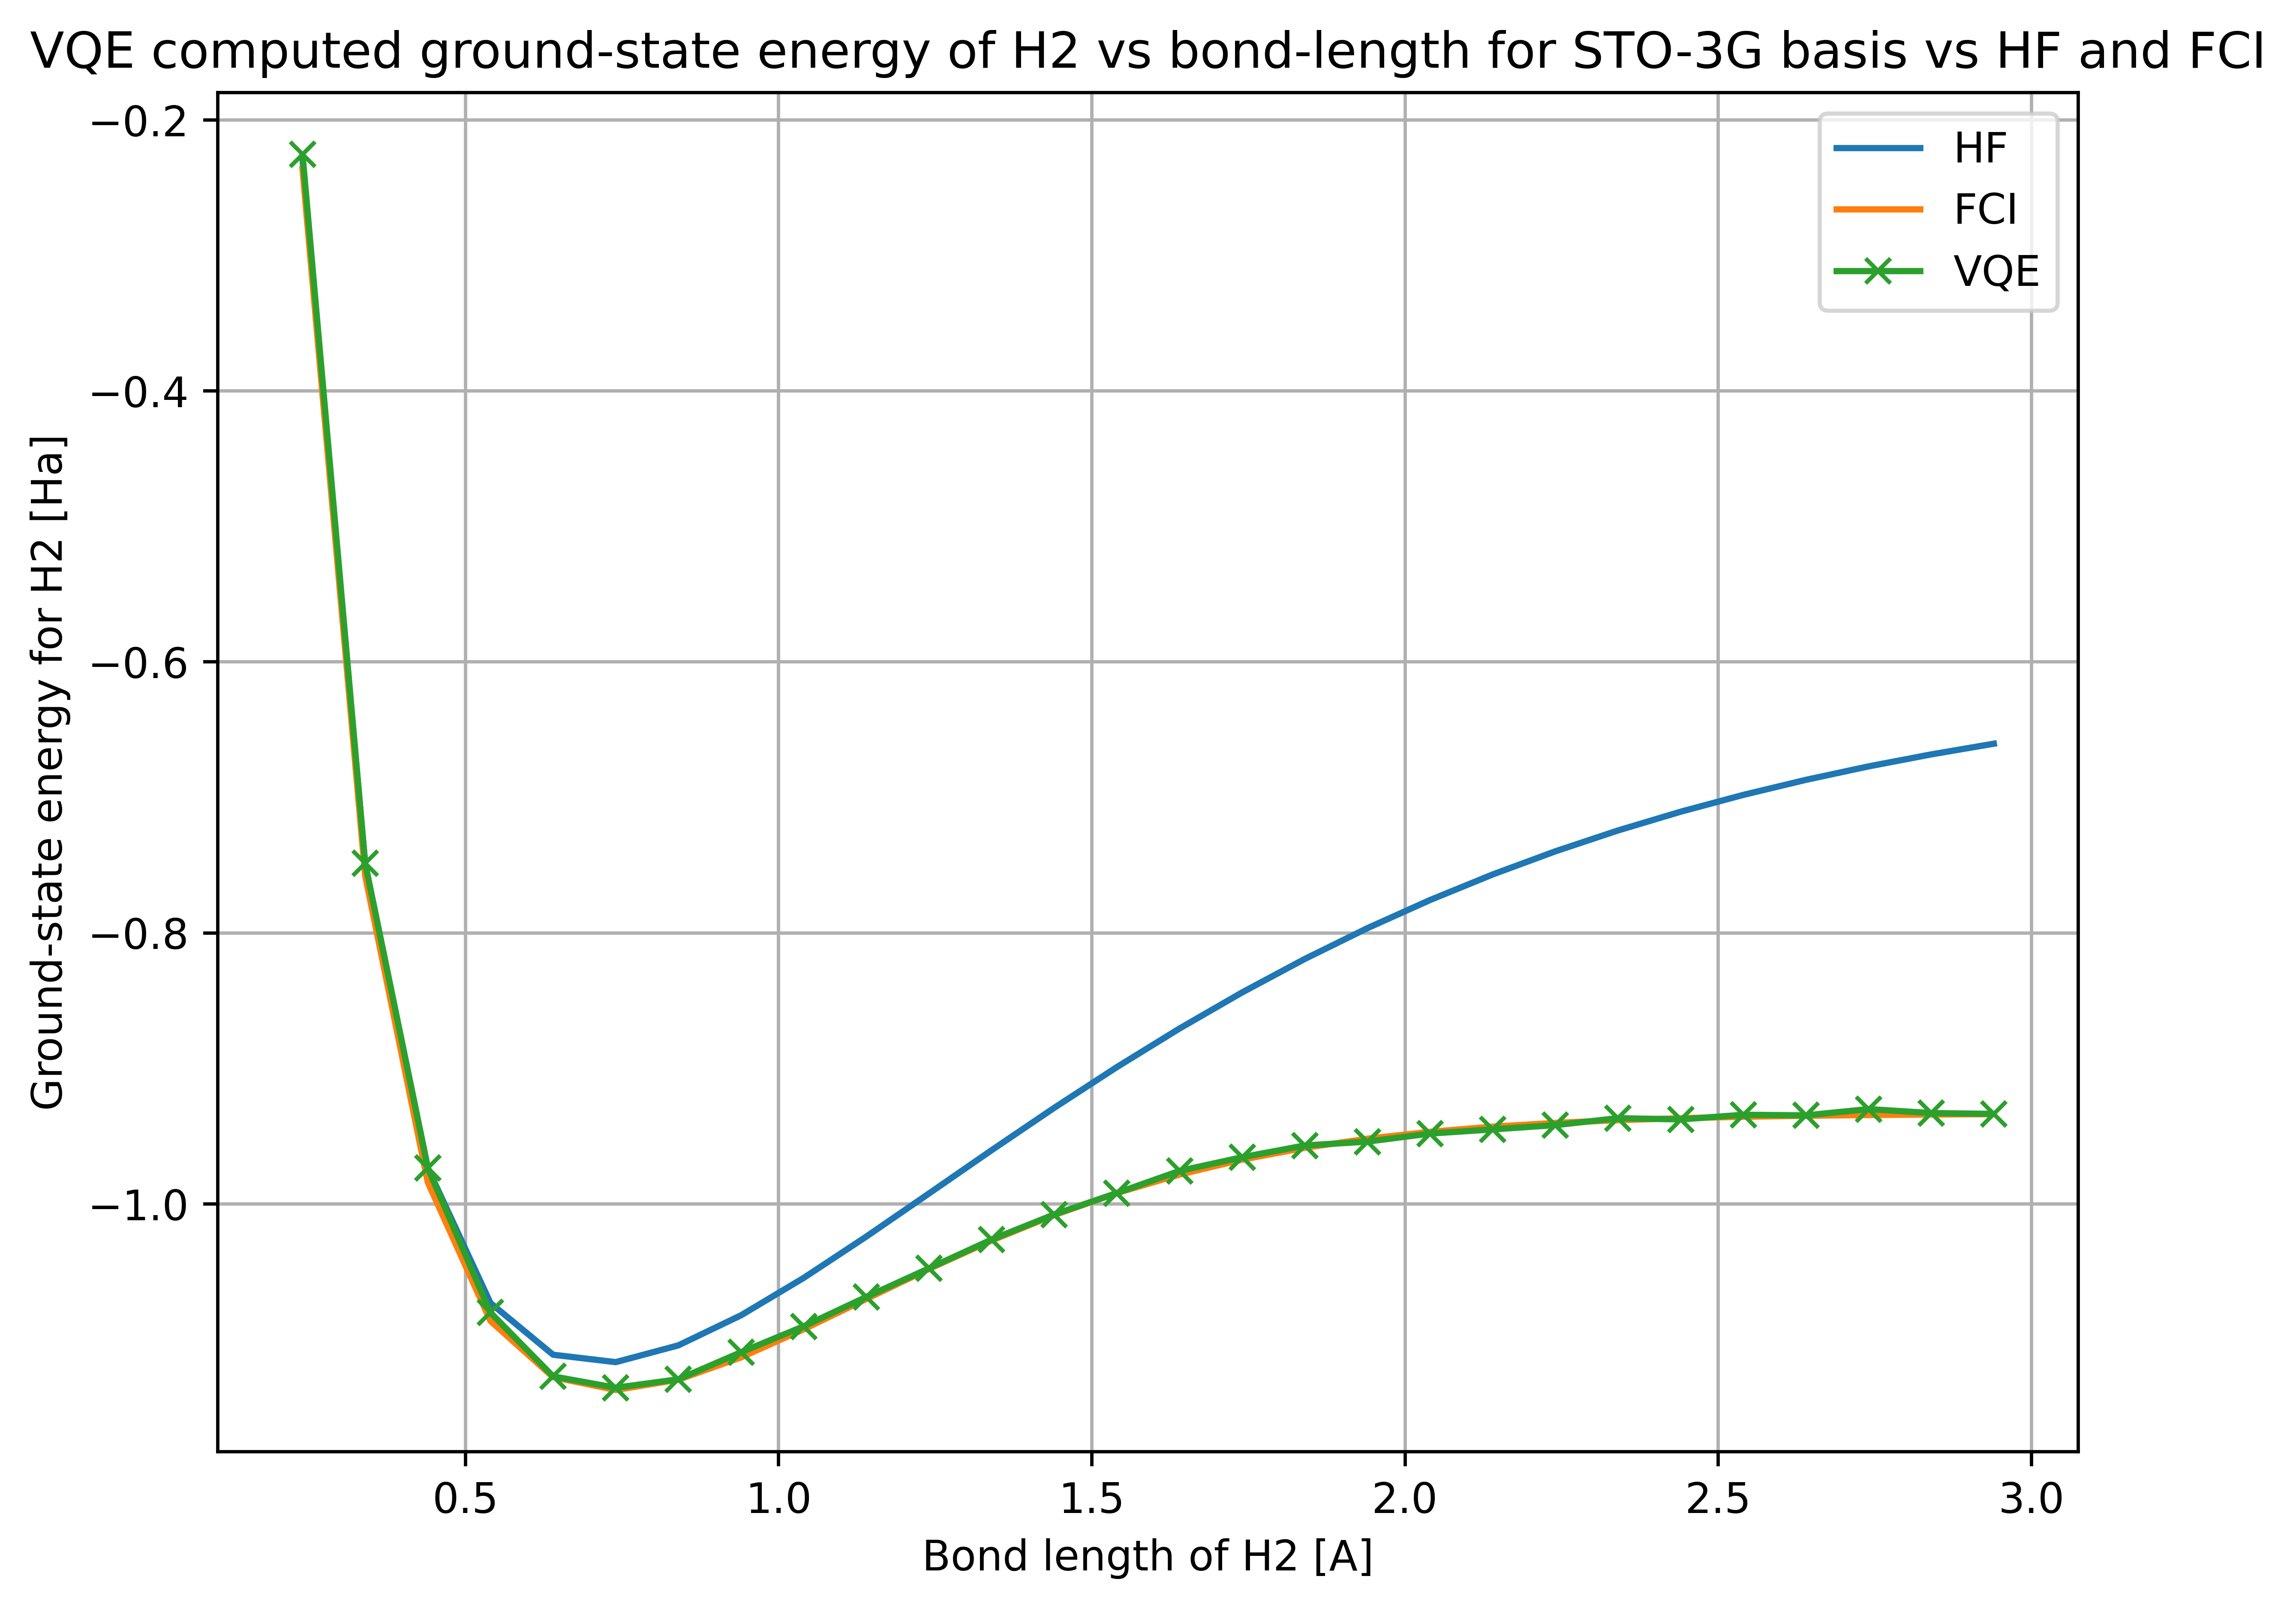

In [8]:
# Plot ground-state energy for each configuration vs bond length
plt.figure(figsize=(8,6), dpi=700)
plt.plot(list(mol_configs.keys()), [val[0].hf_energy for val in mol_configs.values()], label='HF')
plt.plot(list(mol_configs.keys()), [val[0].fci_energy for val in mol_configs.values()], label='FCI')
plt.plot(list(mol_configs.keys()), [val[2] for val in mol_configs.values()], 'x-', label='VQE')
plt.grid()
plt.xlabel('Bond length of H2 [A]')
plt.ylabel('Ground-state energy for H2 [Ha]')
plt.legend()
plt.title('VQE computed ground-state energy of H2 vs bond-length for STO-3G basis vs HF and FCI')
plt.savefig('H2_PES_byVQE.png')
run_time = time.time()-run_time
print(f"Total running time: {run_time:.2f} s")

# Discussion
In the plot of the computed ground-state energy of the $H_2$ molecule against its bond length above, the curve labeled "HF" denotes the ground-state energy computed by using the classical Hartree-Fock method, i.e., classical pre-computation alone.
The curve labeled "FCI" denotes the ground-state energy of $H_2$ for each bond-length computed using one of the most accurate classical post-Hartree-Fock method, viz., Full Configuration Interaction (FCI).
As can be seen from the curve labeled "VQE" in the plot above, the computational results of the quantum computational method VQE agree extremely well with the FCI results over the entire range of bond-lengths simulated for the $H_2$ molecule.
This shows that the quantum computational VQE method can be very competitive with the most accurate classical computational chemistry methods.

# References
[1] Helgaker, T., Jorgensen, P., & Olsen, J. (2014). *Molecular
electronic-structure theory*. John Wiley & Sons.  

[2] McArdle, S., Endo, S., Aspuru-Guzik, A., Benjamin, S., & Yuan, X. (2020). Quantum computational chemistry. *Reviews of Modern Physics, 92(1)*.  

[3] Cao, Y., Romero J., Olson, J. P., Degroote, M., Johnson, P. D., Kieferov, M., Kivlichan, I. D., Menke, T., Peropadre, B., Sawaya, N. P. D., Sim, S., Veis, L., &  Aspuru-Guzik A. (2018). Quantum chemistry in the age of quantum computing. *Chemical Reviews, 119(19)*, 10856–10915.  

[4] Hempel, C., Maier, C., Romero, J., McClean, J., Monz, T., Shen, H., Jurcevic, P., Lanyon, B. P.,  Love, P., Babbush, R.,  Aspuru-Guzik, A., Blatt, R., & Roos C. F. (2018). Quantum Chemistry Calculations on a Trapped-Ion Quantum Simulator. *Phys.Rev. X, 8(3)*, 031022.  

[5] McClean, J. R., Sung, K. J., Kivlichan, I. D., Bonet-Monroig, X., Cao, Y., Dai, C., Fried, E. S., Gidney, C.,  Gimby, B., Gokhale, P., Häner, T., Hardikar, T., Havlíček, V., Higgott, O., Huang, C., Izaac, J., Jiang, Z., Kirby, W., Liu, X., ..., Babbush, R. (2017). OpenFermion: The electronic structure package for quantum computers. *arXiv:1710.07629*.  

[6] Sun, Q., Berkelbach, T. C., Blunt, N. S., Booth, G. H., Guo, S., Li, Z., Liu, J., McClain, J., Sayfutyarova, E. R., Sharma,  S., Wouters,  S., & Chan, G. K.-L. (2017). The Python-based simulations of chemistry framework (PySCF). *WIREs Compututational Molecular Science, 8(e1340).*  

[7] Sun. Q. (2015).  Libcint: An efficient general integral library for Gaussian basis functions. *J. Comp. Chem. 36(1664)*.
